In [2]:
#library(PROPER)
library(limma)
library(ggplot2)
library(Matrix)
library(rhdf5)
library(sva)
#library(qvalue)
#library(fdrtool)
#library(DSS)
#library(DESeq2) 
source("limma-voom.R")

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel



In [3]:
file_path = "/storage10/shuchen/JerberData/alltime_fiaj_12100_5000.mtx"
meta_path = "/storage10/shuchen/JerberData/alltime_fiaj_12100_5000.h5"
h5ls(meta_path)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,X,H5I_GROUP,,
1,/X,data,H5I_DATASET,FLOAT,10938528
2,/X,indices,H5I_DATASET,INTEGER,10938528
3,/X,indptr,H5I_DATASET,INTEGER,12101
4,/,layers,H5I_GROUP,,
5,/,obs,H5I_GROUP,,
6,/obs,celltype,H5I_GROUP,,
7,/obs/celltype,categories,H5I_DATASET,STRING,11
8,/obs/celltype,codes,H5I_DATASET,INTEGER,12100


In [4]:
data <- t(readMM(file_path))
cell_type <- h5read(meta_path, name="obs/celltype")
sample_id <- h5read(meta_path, name="obs/sample_id")
pool_id <- h5read(meta_path, name="obs/pool_id")
time_point <- h5read(meta_path, name="obs/time_point")
treatment <- h5read(meta_path, name="obs/treatment")
gene <- h5read(meta_path, name="var")

In [5]:
get_categories <- function(meta) {
    names = meta$codes
    for (i in 1:length(meta$categories)) {
        name = meta$categories[i]
        names[meta$codes==(i-1)] = name
    }
    return(names)
}

In [6]:
cell_type <- get_categories(cell_type)
sample_id <- get_categories(sample_id)
pool_id <- get_categories(pool_id)
time_point <- get_categories(time_point)
treatment <- get_categories(treatment)

In [ ]:
data_pool <- ComBat(data, pool_id)
data_sample <- ComBat(data, sample_id)

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Found 694 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found30batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes



In [7]:
unique(treatment)

[1] "NONE" "ROT"

In [12]:
min(data_pool[,which(time_point=="D52")])

[1] -1.861066

In [13]:
temp_data = data_pool[,which(time_point=="D52")] - min(data_pool[,which(time_point=="D52")])

In [18]:
dim(temp_data)

[1] 5000 7299

In [22]:
unique(as.factor(treatment[which(time_point=="D52")]))

[1] NONE ROT 
Levels: NONE ROT

In [23]:
res <- DE_limmavoom(counts=temp_data, group=as.factor(treatment[which(time_point=="D52")]), contrfml = "groupROT-groupNONE", 
                    cutoff=1.0, thres_type="adjp",
                    p_thres=0.05, lfc_thres=0, adj_method = "BH")

[1] "5000 out of 5000 genes left after filtering low-expressed genes"
           Contrasts
Levels      groupROT-groupNONE
  groupNONE                 -1
  groupROT                   1


In [1]:
res <- DE_limmavoom(counts=data_pool, group=as.factor(time_point), contrfml = "groupD30-groupD11", 
                    cutoff=1.0, thres_type="adjp",
                    p_thres=0.05, lfc_thres=0, adj_method = "BH")

ERROR: Error in DE_limmavoom(counts = data_pool, group = as.factor(time_point), : could not find function "DE_limmavoom"


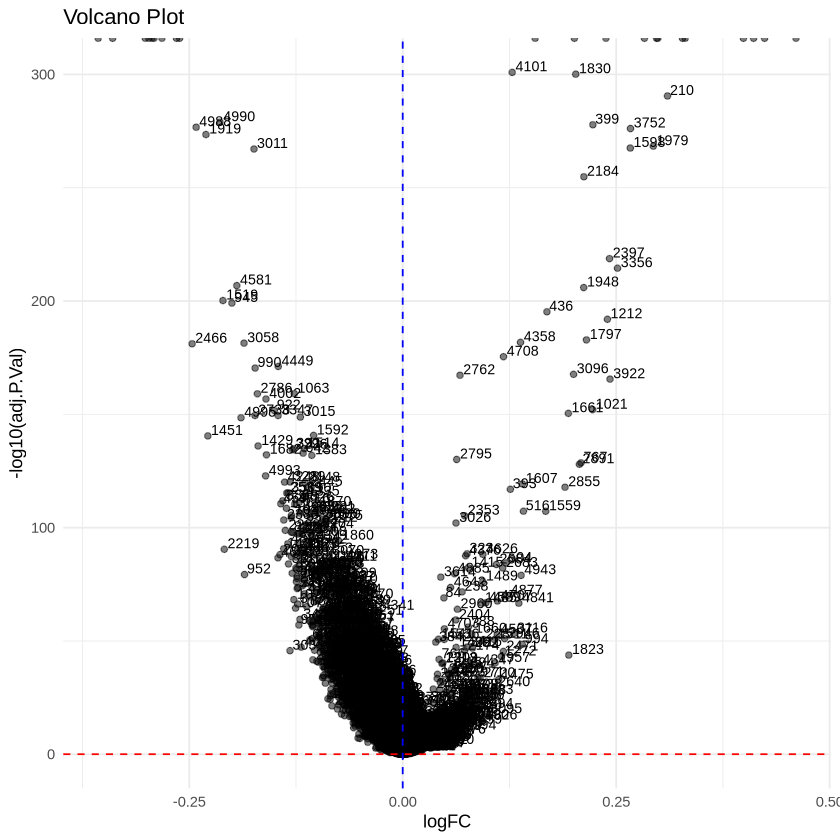

In [24]:
res$volcano_plot

In [26]:
res$toptable

,logFC,AveExpr,t,P.Value,adj.P.Val,B,genes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
141,-0.2819841,8.099267,-46.39235,0.000000e+00,0.000000e+00,934.7449,141
366,0.1550754,7.907765,41.07144,0.000000e+00,0.000000e+00,750.1890,366
1215,0.3990427,8.408505,49.63994,0.000000e+00,0.000000e+00,1053.1896,1215
1414,0.2988315,8.146877,41.16309,0.000000e+00,0.000000e+00,753.4570,1414
1529,0.4237746,8.201469,56.18111,0.000000e+00,0.000000e+00,1303.3888,1529
1530,0.4605674,8.154922,68.03650,0.000000e+00,0.000000e+00,1784.7563,1530
2547,0.2973016,8.134548,42.75325,0.000000e+00,0.000000e+00,807.2245,2547
2794,0.4109373,8.365978,50.33134,0.000000e+00,0.000000e+00,1078.9605,2794
3064,0.2379677,8.017191,42.70916,0.000000e+00,0.000000e+00,805.6901,3064


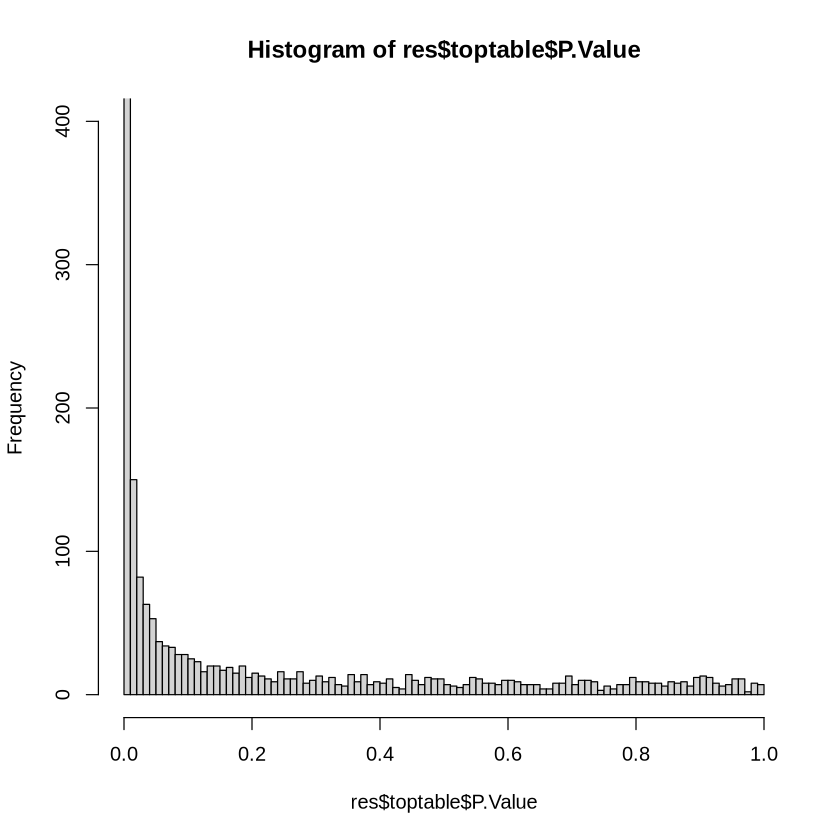

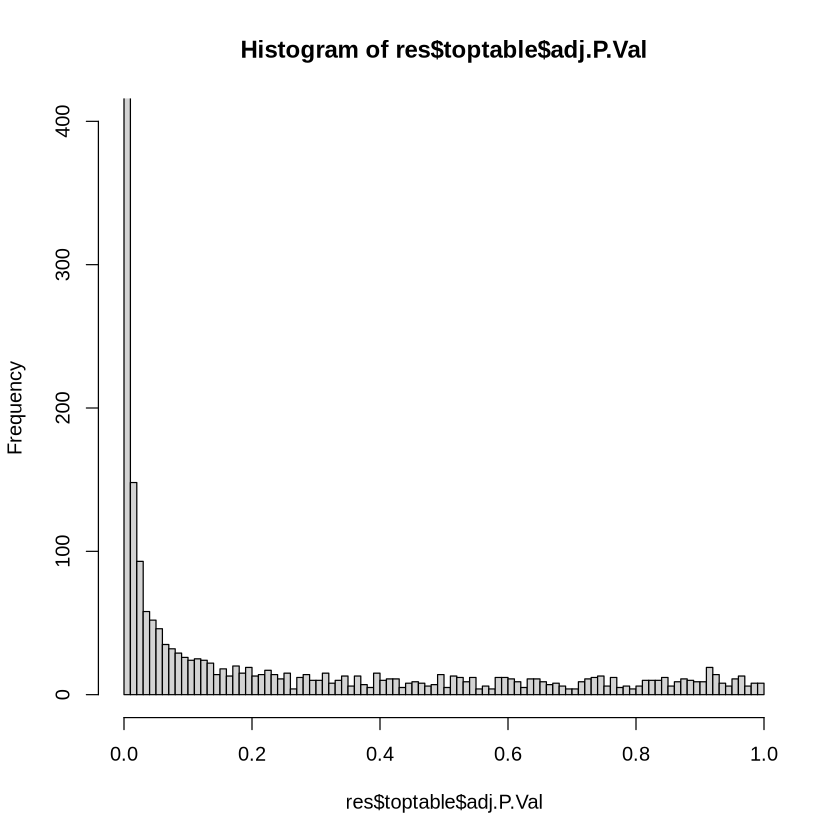

In [27]:
hist(res$toptable$P.Value, breaks=100, xlim=c(0.0, 1.0), ylim=c(0, 400))
hist(res$toptable$adj.P.Val, breaks=100, xlim=c(0.0, 1.0), ylim=c(0, 400))

In [28]:
sum(res$toptable$P.Value < 0.05)

[1] 3938

In [ ]:
# complete.results_Cheung <- na.omit(results_Cheung)
res_fdr <- fdrtool(res$toptable$t, statistic = "normal", plot = TRUE)

hist(res$toptable$t, breaks=20)
hist(res_fdr$pval, breaks=20)
hist(res_fdr$lfdr, breaks=20)
hist(res_fdr$qval, breaks=20)

In [ ]:
res$predicted <- ifelse(1:nrow(sim.data$counts) %in% res$de_genes, "DE", "Not DE")
res$actual <- ifelse(1:nrow(sim.data$counts) %in% sim.data$DEid, "DE", "Not DE")
confusion_matrix <- table(res$actual, res$predicted)
sum(res$predicted=="DE")
sum(res$actual=="DE")

metrics <- calculate_metrics(confusion_matrix)
metrics